In [ ]:
import numpy as np
from tqdm import tqdm
from multiprocessing import Pool
import torch
import pandas as pd
import numpy as np
import pickle
from tqdm import tqdm
import os
from Bio.Align import substitution_matrices

In [2]:
DATA_ROOT = '../data'
from multiprocessing import Pool
import torch
import pandas as pd
import numpy as np
import pickle
from tqdm import tqdm
import os
from sklearn.model_selection import GroupKFold
from torch.utils.data import Subset
def load_data(config):
    dataset_name = config.dataset
    split_type = getattr(config, 'split', '')
    if dataset_name == 'seqlevel_data':
        dataset = SeqLevelDataset(config)
        if split_type == 'cv-new_epitope':
            epi2cluster = get_cluster(dataset_name, split_type)
            epi_id = dataset.get_all_epiid()
            group_id = [epi2cluster[epi_this] for epi_this in epi_id]

            kfold = GroupKFold(5)
            splits = kfold.split(epi_id, groups=group_id)
            datasets_cv = {'train':[],'val':[]}
            for train_idx, val_idx in splits:
                datasets_cv['train'].append(Subset(dataset, train_idx))
                datasets_cv['val'].append(Subset(dataset, val_idx))
            return datasets_cv

    elif dataset_name == 'reslevel_data':
        dataset = ResLevelDataset(config)
        if split_type in ['cv-both_new', 'cv-new_cdr3', 'cv-new_epi']:
            cdr32cluster, epi2cluster = get_cluster(dataset_name, split_type)

            kfold = GroupKFold(3) if split_type == 'cv-both_new' else GroupKFold(5)
            if len(cdr32cluster) != 0:  # new_cdr3, both_new
                all_cdr3= dataset.get_all_values('cdr3_seqs')
                cdr3_group_id = [cdr32cluster[cdr3_this] for cdr3_this in all_cdr3]
                split_cdr3 = list(kfold.split(all_cdr3, groups=cdr3_group_id))
                split = split_cdr3
            if len(epi2cluster) != 0:  # new_epi, both_new
                all_epi = dataset.get_all_values('epi_seqs')
                epi_group_id = [epi2cluster[epi_this] for epi_this in all_epi]
                split_epi = list(kfold.split(all_epi, groups=epi_group_id))
                split = split_epi
            if split_type == 'cv-both_new':
                split = [[np.intersect1d(fold_tcr[0], fold_epi[0]), np.intersect1d(fold_tcr[1], fold_epi[1])]
                    for fold_tcr, fold_epi in zip(split_cdr3, split_epi)]
            
            datasets_cv = {'train':[],'val':[]}
            for train_idx, val_idx in split:
                datasets_cv['val'].append(Subset(dataset, val_idx))
                datasets_cv['train'].append(Subset(dataset, train_idx))
            return datasets_cv

    else:
        raise ValueError('Unknown dataset: {}'.format(dataset_name))

    if (split_type is None) or (split_type == ''):
        print('No split specified, using train as default')
        return dataset
    elif split_type == 'train-val':
        train_ratio = getattr(config, 'train_ratio', 0.8)
        index = np.random.permutation(len(dataset))
        train_set = Subset(dataset, index[:int(len(dataset) * train_ratio)])
        val_set = Subset(dataset, index[int(len(dataset) * train_ratio):])
        return {'train': [train_set], 'val': [val_set]}
    else:
        raise ValueError('Unknown split: {}'.format(split_type))


def get_cluster(dataset_name, split):
    if dataset_name == 'seqlevel_data' and split == 'cv-new_epitope':
        cluster_path = os.path.join(DATA_ROOT, 'cluster/seqlevel_epi_cluster_0.5.pkl')
        with open(cluster_path, 'rb') as f:
            epi2cluster = pickle.load(f, encoding='iso-8859-1')
        epi2cluster = {int(k.split('_')[-1]):v for k, v in epi2cluster.items()}
        return epi2cluster
    if dataset_name == 'reslevel_data':
        cluster_path_dict = {
            'cdr3': os.path.join(DATA_ROOT, 'cluster/reslevel_cdr3_cluster_0.2.pkl'),
            'epi': os.path.join(DATA_ROOT, 'cluster/reslevel_epi_cluster_0.2.pkl'),
        }
        cdr32cluster, epi2cluster = {}, {}
        if ('new_cdr3' in split) or ('both_new' in split):
            with open(cluster_path_dict['cdr3'], 'rb') as f:
                cdr32cluster = pickle.load(f, encoding='iso-8859-1')
        if ('new_epi' in split) or ('both_new' in split):
            with open(cluster_path_dict['epi'], 'rb') as f:
                epi2cluster = pickle.load(f, encoding='iso-8859-1')
        return cdr32cluster, epi2cluster


class ResLevelDataset(torch.utils.data.Dataset):
    def __init__(self, config):
        self.config = config
        path = config.path
        data = self.load_data(path)
        self.data = self.encoding(data)


    def load_data(self, path):
        df = pd.read_csv(os.path.join(path['summary']))

        cdr3_seqs = df['cdr3'].values
        epi_seqs = df['epitope'].values
        pdb_chains = df['pdb_chains'].values
        pdb_mat = []
        for pdb in pdb_chains:
            df_mat = pd.read_csv(os.path.join(path['mat'], pdb + '.csv'), index_col=0)
            pdb_mat.append(df_mat.values)
        return {
            'cdr3': cdr3_seqs,
            'epi': epi_seqs,
            'dist_mat': pdb_mat,
            'pdb_chains': pdb_chains,
        }

    def encoding(self, data):
        cdr3, epi, mat = data['cdr3'], data['epi'], data['dist_mat']
        # with Pool(processes=64) as p:
        #     enc_cdr3 = p.map(encoding_cdr3_single, cdr3)
        #     enc_epi = p.map(encoding_epi_single, epi)
        enc_cdr3 = encoding_cdr3(cdr3)
        enc_epi = encoding_epi(epi)
        enc_dist_mat, masking = encoding_dist_mat(mat)
        enc_contact_mat = np.int64(enc_dist_mat < 5.)

        data['cdr3'] = np.array(enc_cdr3)
        data['epi'] = np.array(enc_epi)
        data['dist_mat'] = np.array(enc_dist_mat)
        data['mask_mat'] = np.array(masking)
        data['contact_mat'] = np.array(enc_contact_mat)
        data['cdr3_seqs'] = cdr3
        data['epi_seqs'] = epi

        return data

    def __len__(self):
        return len(self.data['dist_mat'])

    def __getitem__(self, idx):
        return {key: value[idx] for key, value in self.data.items()}

        
    def get_all_values(self, key):
        return self.data[key]

    # def get_max_dist(self):
    #     return np.max(self.data['dist_mat'], axis=0)

In [3]:
import numpy as np
from tqdm import tqdm
from Bio.Align import substitution_matrices
import sys
sys.path.append('.')


def GetBlosumMat(residues_list):
    n_residues = len(residues_list)  # the number of amino acids _ 'X'
    blosum62_mat = np.zeros([n_residues, n_residues])  # plus 1 for gap
    bl_dict = substitution_matrices.load('BLOSUM62')
    for pair, score in bl_dict.items():
        if (pair[0] not in residues_list) or (pair[1] not in residues_list):  # special residues not considered here
            continue
        idx_pair0 = residues_list.index(pair[0])  # index of residues
        idx_pair1 = residues_list.index(pair[1])
        blosum62_mat[idx_pair0, idx_pair1] = score
        blosum62_mat[idx_pair1, idx_pair0] = score
    return blosum62_mat


class Tokenizer:
    def __init__(self,):
        self.res_all = ['G', 'A', 'V', 'L', 'I', 'F', 'W', 'Y', 'D', 'N',
                     'E', 'K', 'Q', 'M', 'S', 'T', 'C', 'P', 'H', 'R'] #+ ['X'] #BJZOU
        self.tokens = ['-'] + self.res_all # '-' for padding encoding

    def tokenize(self, index): # int 2 str
        return self.tokens[index]

    def id(self, token): # str 2 int
        try:
            return self.tokens.index(token.upper())
        except ValueError:
            print('Error letter in the sequences:', token)
            if str.isalpha(token):
                return self.tokens.index('X')

    def tokenize_list(self, seq):
        return [self.tokenize(i) for i in seq]

    def id_list(self, seq):
        return [self.id(s) for s in seq]

    def embedding_mat(self):
        blosum62 = GetBlosumMat(self.res_all)
        mat = np.eye(len(self.tokens))
        mat[1:len(self.res_all) + 1, 1:len(self.res_all) + 1] = blosum62
        return mat

tokenizer = Tokenizer()


def encoding_epi(seqs, max_len=12):
    encoding = np.zeros([len(seqs), max_len], dtype='long')
    for i, seq in tqdm(enumerate(seqs), desc='Encoding epi seqs', total=len(seqs)):
        len_seq = len(seq)
        if len_seq == 8:
            encoding[i, 2:len_seq+2] = tokenizer.id_list(seq)
        elif (len_seq == 9) or (len_seq == 10):
            encoding[i, 1:len_seq+1] = tokenizer.id_list(seq)
        else:
            encoding[i, :len_seq] = tokenizer.id_list(seq)
    return encoding

def encoding_cdr3(seqs, max_len=20):
    encoding = np.zeros([len(seqs), max_len], dtype='long')
    for i, seq in tqdm(enumerate(seqs), desc='Encoding cdr3s', total=len(seqs)):
        len_seq = len(seq)
        i_start =  max_len // 2 - len_seq // 2
        encoding[i, i_start:i_start+len_seq] = tokenizer.id_list(seq)
    return encoding

def encoding_cdr3_single(seq, max_len=20):
    encoding = np.zeros(max_len, dtype='long')
    len_seq = len(seq)
    i_start =  max_len // 2 - len_seq // 2
    encoding[i_start:i_start+len_seq] = tokenizer.id_list(seq)
    return encoding

def encoding_epi_single(seq, max_len=12):
    encoding = np.zeros(max_len, dtype='long')
    len_seq = len(seq)
    if len_seq == 8:
        encoding[2:len_seq+2] = tokenizer.id_list(seq)
    elif (len_seq == 9) or (len_seq == 10):
        encoding[1:len_seq+1] = tokenizer.id_list(seq)
    else:
        encoding[:len_seq] = tokenizer.id_list(seq)
    return encoding


def encoding_dist_mat(mat_list, max_cdr3=20, max_epi=12):
    encoding = np.zeros([len(mat_list), max_cdr3, max_epi], dtype='float32')
    masking = np.zeros([len(mat_list), max_cdr3, max_epi], dtype='bool')
    for i, mat in tqdm(enumerate(mat_list), desc='Encoding dist mat', total=len(mat_list)):
        len_cdr3, len_epi = mat.shape
        i_start_cdr3 = max_cdr3 // 2 - len_cdr3 // 2
        if len_epi == 8:
            i_start_epi = 2
        elif (len_epi == 9) or (len_epi == 10):
            i_start_epi = 1
        else:
            i_start_epi = 0
        encoding[i, i_start_cdr3:i_start_cdr3+len_cdr3, i_start_epi:i_start_epi+len_epi] = mat
        masking[i, i_start_cdr3:i_start_cdr3+len_cdr3, i_start_epi:i_start_epi+len_epi] = True
    return encoding, masking


def decoding_one_mat(mat, len_cdr3, len_epi):
    decoding = np.zeros([len_cdr3, len_epi] + list(mat.shape[2:]), dtype=mat.dtype)
    i_start_cdr3 = 10 - len_cdr3 // 2
    if len_epi == 8:
        i_start_epi = 2
    elif (len_epi == 9) or (len_epi == 10):
        i_start_epi = 1
    else:
        i_start_epi = 0
    decoding = mat[i_start_cdr3:i_start_cdr3+len_cdr3, i_start_epi:i_start_epi+len_epi] 
    return decoding

In [4]:
import numpy as np
from easydict import EasyDict
import yaml
import torch
from sklearn.metrics import roc_auc_score, average_precision_score, median_absolute_error, roc_auc_score
from scipy.stats import pearsonr

def load_config(path):
    with open(path, 'r') as f:
        return EasyDict(yaml.safe_load(f))

def load_model_from_ckpt(path, model: torch.nn.Module):
    pl_model = torch.load(path)
    if 'state_dict' in pl_model:
        pl_model = pl_model['state_dict'] # from lightning module
    state_dict = {k[k.find('.')+1:]: v for k, v in pl_model.items()}
    model.load_state_dict(state_dict)
    return model

def calc_auc_aupr(y_true, y_pred):
    auc = roc_auc_score(y_true, y_pred)
    aupr = average_precision_score(y_true, y_pred)
    return auc, aupr

def get_scores_dist(y_true, y_pred, y_mask):
    coef, mae, mape = [], [], []
    for y_true_, y_pred_, y_mask_ in zip(y_true, y_pred, y_mask):
        y_true_ = y_true_[y_mask_.astype('bool')]
        y_pred_ = y_pred_[y_mask_.astype('bool')]
        try:
            coef_, _ = pearsonr(y_true_, y_pred_)
        except Exception:
            coef_ = np.nan
        coef.append(coef_)

        mae_ = median_absolute_error(y_true_, y_pred_)
        mae.append(mae_)

        mape_ = np.median(np.abs((np.array(y_true_) - np.array(y_pred_)) / np.array(y_true_)))
        mape.append(mape_)
    avg_coef = np.nanmean(coef)
    avg_mae = np.mean(mae)
    avg_mape = np.mean(mape)
    return [avg_coef, avg_mae, avg_mape], [coef, mae, mape]


def get_scores_contact(y_true, y_pred, y_mask):
    coef = []
    for y_true_, y_pred_, y_mask_ in zip(y_true, y_pred, y_mask):
        # y_true_, y_pred_, y_mask_ = y_true_.reshape([-1]), y_pred_.reshape([-1]), y_mask_.reshape([-1]).astype('bool')
        y_true_ = y_true_[y_mask_.astype('bool')]
        y_pred_ = y_pred_[y_mask_.astype('bool')]
        try:
            coef_ = roc_auc_score(y_true_, y_pred_)
        except Exception:
            coef_ = np.nan
        coef.append(coef_)

    avg_coef = np.mean(coef)
    return [avg_coef], [coef]

In [5]:
import math
from sklearn import metrics
from sklearn import preprocessing
import matplotlib.pyplot as plt
plt.rcParams['font.size'] = 12
import numpy as np
import pandas as pd
import re
import time
import datetime
import random
random.seed(1234)

from scipy import interp
import warnings
warnings.filterwarnings("ignore")

from collections import Counter
from functools import reduce
from tqdm import tqdm, trange
from copy import deepcopy

from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_auc_score, auc
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import classification_report
from sklearn.utils import class_weight

import os
import torch
import torch.nn as nn
from torch.nn import functional as F
import torch.optim as optim
import torch.utils.data as Data
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
seed = 2022
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
torch.backends.cudnn.benchmark = False
torch.backends.cudnn.deterministic = True

In [6]:
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, dropout=0.1, max_len=5000):
        super(PositionalEncoding, self).__init__()
        self.dropout = nn.Dropout(p=dropout)

        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0).transpose(0, 1)
        self.register_buffer('pe', pe)

    def forward(self, x):
        '''
        x: [seq_len, batch_size, d_model]
        '''
        x = x + self.pe[:x.size(0), :]
        return self.dropout(x)

def get_attn_pad_mask(seq_q, seq_k):
    '''
    seq_q: [batch_size, seq_len]
    seq_k: [batch_size, seq_len]
    seq_len could be src_len or it could be tgt_len
    seq_len in seq_q and seq_len in seq_k maybe not equal
    '''
    batch_size, len_q = seq_q.size()
    batch_size, len_k = seq_k.size()
    # eq(zero) is PAD token
    pad_attn_mask = seq_k.data.eq(0).unsqueeze(1)  # [batch_size, 1, len_k], False is masked
    return pad_attn_mask.expand(batch_size, len_q, len_k)  # [batch_size, len_q, len_k]

class ScaledDotProductAttention(nn.Module):
    def __init__(self):
        super(ScaledDotProductAttention, self).__init__()

    def forward(self, Q, K, V, attn_mask):
        '''
        Q: [batch_size, n_heads, len_q, d_k]
        K: [batch_size, n_heads, len_k, d_k]
        V: [batch_size, n_heads, len_v(=len_k), d_v]
        attn_mask: [batch_size, n_heads, seq_len, seq_len]
        '''
        scores = torch.matmul(Q, K.transpose(-1, -2)) / np.sqrt(d_k) # scores : [batch_size, n_heads, len_q, len_k]
        scores.masked_fill_(attn_mask, -1e9) # Fills elements of self tensor with value where mask is True.
        attn = scores
        # attn = nn.Softmax(dim=-1)(scores)
        context = torch.matmul(attn, V) # [batch_size, n_heads, len_q, d_v]
        return context, attn


# In[17]:


class MultiHeadAttention(nn.Module):
    def __init__(self):
        super(MultiHeadAttention, self).__init__()
        self.use_cuda = use_cuda
        device = torch.device("cuda" if self.use_cuda else "cpu")
        self.W_Q = nn.Linear(d_model, d_k * n_heads, bias=False)
        self.W_K = nn.Linear(d_model, d_k * n_heads, bias=False)
        self.W_V = nn.Linear(d_model, d_v * n_heads, bias=False)
        self.fc = nn.Linear(n_heads * d_v, d_model, bias=False)
    def forward(self, input_Q, input_K, input_V, attn_mask):
        '''
        input_Q: [batch_size, len_q, d_model]
        input_K: [batch_size, len_k, d_model]
        input_V: [batch_size, len_v(=len_k), d_model]
        attn_mask: [batch_size, seq_len, seq_len]
        '''
        residual, batch_size = input_Q, input_Q.size(0)
        # (B, S, D) -proj-> (B, S, D_new) -split-> (B, S, H, W) -trans-> (B, H, S, W)
        Q = self.W_Q(input_Q).view(batch_size, -1, n_heads, d_k).transpose(1,2)  # Q: [batch_size, n_heads, len_q, d_k]
        K = self.W_K(input_K).view(batch_size, -1, n_heads, d_k).transpose(1,2)  # K: [batch_size, n_heads, len_k, d_k]
        V = self.W_V(input_V).view(batch_size, -1, n_heads, d_v).transpose(1,2)  # V: [batch_size, n_heads, len_v(=len_k), d_v]

        attn_mask = attn_mask.unsqueeze(1).repeat(1, n_heads, 1, 1) # attn_mask : [batch_size, n_heads, seq_len, seq_len]

        # context: [batch_size, n_heads, len_q, d_v], attn: [batch_size, n_heads, len_q, len_k]
        context, attn = ScaledDotProductAttention()(Q, K, V, attn_mask)
        context = context.transpose(1, 2).reshape(batch_size, -1, n_heads * d_v) # context: [batch_size, len_q, n_heads * d_v]
        output = self.fc(context) # [batch_size, len_q, d_model]
        return nn.LayerNorm(d_model).to(device)(output + residual), attn


# In[18]:


class PoswiseFeedForwardNet(nn.Module):
    def __init__(self):
        super(PoswiseFeedForwardNet, self).__init__()
        self.use_cuda = use_cuda
        device = torch.device("cuda" if self.use_cuda else "cpu")
        self.fc = nn.Sequential(
            nn.Linear(d_model, d_ff, bias=False),
            nn.ReLU(),
            nn.Linear(d_ff, d_model, bias=False)
        )
    def forward(self, inputs):
        '''
        inputs: [batch_size, seq_len, d_model]
        '''
        residual = inputs
        output = self.fc(inputs)
        return nn.LayerNorm(d_model).to(device)(output + residual) # [batch_size, seq_len, d_model]


# In[19]:


class EncoderLayer(nn.Module):
    def __init__(self):
        super(EncoderLayer, self).__init__()
        self.enc_self_attn = MultiHeadAttention()
        self.pos_ffn = PoswiseFeedForwardNet()

    def forward(self, enc_inputs, enc_self_attn_mask):
        '''
        enc_inputs: [batch_size, src_len, d_model]
        enc_self_attn_mask: [batch_size, src_len, src_len]
        '''
        # enc_outputs: [batch_size, src_len, d_model], attn: [batch_size, n_heads, src_len, src_len]
        enc_outputs, attn = self.enc_self_attn(enc_inputs, enc_inputs, enc_inputs, enc_self_attn_mask) # enc_inputs to same Q,K,V
        enc_outputs = self.pos_ffn(enc_outputs) # enc_outputs: [batch_size, src_len, d_model]
        return enc_outputs, attn


# In[20]:


class Encoder(nn.Module):
    def __init__(self):
        super(Encoder, self).__init__()
        self.src_emb = nn.Embedding(vocab_size, d_model)
        self.pos_emb = PositionalEncoding(d_model)
        self.layers = nn.ModuleList([EncoderLayer() for _ in range(n_layers)])

    def forward(self, enc_inputs):
        '''
        enc_inputs: [batch_size, src_len]
        '''
        enc_outputs = self.src_emb(enc_inputs) # [batch_size, src_len, d_model]
        enc_outputs = self.pos_emb(enc_outputs.transpose(0, 1)).transpose(0, 1) # [batch_size, src_len, d_model]
        enc_self_attn_mask = get_attn_pad_mask(enc_inputs, enc_inputs) # [batch_size, src_len, src_len]
        enc_self_attns = []
        for layer in self.layers:
            # enc_outputs: [batch_size, src_len, d_model], enc_self_attn: [batch_size, n_heads, src_len, src_len]
            enc_outputs, enc_self_attn = layer(enc_outputs, enc_self_attn_mask)
            enc_self_attns.append(enc_self_attn)
        return enc_outputs, enc_self_attns


# ### Decoder

# In[21]:


class DecoderLayer(nn.Module):
    def __init__(self):
        super(DecoderLayer, self).__init__()
        self.dec_self_attn = MultiHeadAttention()
        self.pos_ffn = PoswiseFeedForwardNet()

    def forward(self, dec_inputs, dec_self_attn_mask): # dec_inputs = enc_outputs
        '''
        dec_inputs: [batch_size, tgt_len, d_model]
        enc_outputs: [batch_size, src_len, d_model]
        dec_self_attn_mask: [batch_size, tgt_len, tgt_len]
        '''
        # dec_outputs: [batch_size, tgt_len, d_model], dec_self_attn: [batch_size, n_heads, tgt_len, tgt_len]
        dec_outputs, dec_self_attn = self.dec_self_attn(dec_inputs, dec_inputs, dec_inputs, dec_self_attn_mask)
        dec_outputs = self.pos_ffn(dec_outputs) # [batch_size, tgt_len, d_model]
        return dec_outputs, dec_self_attn


# In[22]:


class Decoder(nn.Module):
    def __init__(self):
        super(Decoder, self).__init__()
#         self.tgt_emb = nn.Embedding(d_model * 2, d_model)
        self.use_cuda = use_cuda
        device = torch.device("cuda" if self.use_cuda else "cpu")
        self.pos_emb = PositionalEncoding(d_model)
        self.layers = nn.ModuleList([DecoderLayer() for _ in range(n_layers)])
        self.tgt_len = tgt_len
        
    def forward(self, dec_inputs): # dec_inputs = enc_outputs (batch_size, peptide_hla_maxlen_sum, d_model)
        '''
        dec_inputs: [batch_size, tgt_len]
        enc_intpus: [batch_size, src_len]
        enc_outputs: [batsh_size, src_len, d_model]
        '''
#         dec_outputs = self.tgt_emb(dec_inputs) # [batch_size, tgt_len, d_model]
        dec_outputs = self.pos_emb(dec_inputs.transpose(0, 1)).transpose(0, 1).to(device) # [batch_size, tgt_len, d_model]
#         dec_self_attn_pad_mask = get_attn_pad_mask(dec_inputs, dec_inputs).cuda() # [batch_size, tgt_len, tgt_len]
        dec_self_attn_pad_mask = torch.LongTensor(np.zeros((dec_inputs.shape[0], tgt_len, tgt_len))).bool().to(device)
 
        dec_self_attns = []
        for layer in self.layers:
            # dec_outputs: [batch_size, tgt_len, d_model], dec_self_attn: [batch_size, n_heads, tgt_len, tgt_len], dec_enc_attn: [batch_size, h_heads, tgt_len, src_len]
            dec_outputs, dec_self_attn = layer(dec_outputs, dec_self_attn_pad_mask)
            dec_self_attns.append(dec_self_attn)
            
        return dec_outputs, dec_self_attns


# ### Transformer

# In[23]:


class Transformer(nn.Module):
    def __init__(self):
        super(Transformer, self).__init__()
        self.use_cuda = use_cuda
        device = torch.device("cuda" if use_cuda else "cpu")
        self.pep_encoder = Encoder().to(device)
        self.hla_encoder = Encoder().to(device)
        self.decoder = Decoder().to(device)
        self.tgt_len = tgt_len
        self.projection = nn.Sequential(
                                        nn.Linear(tgt_len * d_model, 256),
                                        nn.ReLU(True),

                                        nn.BatchNorm1d(256),
                                        nn.Linear(256, 64),
                                        nn.ReLU(True),

                                        #output layer
                                        nn.Linear(64, 2)
                                        ).to(device)
        
    def forward(self, hla_inputs,pep_inputs):
        '''
        pep_inputs: [batch_size, pep_len]
        hla_inputs: [batch_size, hla_len]
        '''
        # tensor to store decoder outputs
        # outputs = torch.zeros(batch_size, tgt_len, tgt_vocab_size).to(self.device)
        
        # enc_outputs: [batch_size, src_len, d_model], enc_self_attns: [n_layers, batch_size, n_heads, src_len, src_len]
        hla_enc_outputs, hla_enc_self_attns = self.hla_encoder(hla_inputs)
        pep_enc_outputs, pep_enc_self_attns = self.pep_encoder(pep_inputs)
        
#         print(hla_enc_outputs)
        enc_outputs = torch.cat((hla_enc_outputs,pep_enc_outputs), 1) # concat pep & hla embedding
        ## reverse ##
#         enc_outputs = pep_enc_outputs*hla_enc_outputs
        
        ## end ##
        # dec_outpus: [batch_size, tgt_len, d_model], dec_self_attns: [n_layers, batch_size, n_heads, tgt_len, tgt_len], dec_enc_attn: [n_layers, batch_size, tgt_len, src_len]
        dec_outputs, dec_self_attns = self.decoder(enc_outputs)
        dec_outputs = dec_outputs.view(dec_outputs.shape[0], -1) # Flatten [batch_size, tgt_len * d_model]
        dec_logits = self.projection(dec_outputs) # dec_logits: [batch_size, tgt_len, tgt_vocab_size]

        return dec_logits.view(-1, dec_logits.size(-1)), pep_enc_self_attns, hla_enc_self_attns, dec_self_attns


In [7]:
pep_max_len = 12 # peptide; enc_input max sequence length
hla_max_len = 20 # hla; dec_input(=dec_output) max sequence length
tgt_len = pep_max_len + hla_max_len
pep_max_len, hla_max_len

# vocab = {'C': 1, 'W': 2, 'V': 3, 'A': 4, 'H': 5, 'T': 6, 'E': 7, 'K': 8, 'N': 9, 'P': 10, 'I': 11, 'L': 12, 'S': 13, 'D': 14, 'G': 15, 'Q': 16, 'R': 17, 'Y': 18, 'F': 19, 'M': 20, '-': 0}
vocab_size = 21

d_model=64 # Embedding Size
d_ff = 256 # FeedForward dimension
d_k = d_v = 64  # dimension of K(=Q), V
n_layers = 1  # number of Encoder of Decoder Layer


n_heads = 5

batch_size = 1024
# batch_size = 5000
epochs = 500
threshold = 0.5

use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")

In [8]:
# path_saver = './train_teim/tcr_st_layer1_multihead5_fold4_netmhcpan.pkl'
# model = Transformer().to(device)
# model.load_state_dict(torch.load(path_saver))

In [9]:
def performances(y_true, y_pred, y_prob, print_ = True):
    
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred, labels = [0, 1]).ravel().tolist()
    accuracy = (tp+tn)/(tn+fp+fn+tp)
    try:
        mcc = ((tp*tn) - (fn*fp)) / np.sqrt(np.float((tp+fn)*(tn+fp)*(tp+fp)*(tn+fn)))
    except:
        print('MCC Error: ', (tp+fn)*(tn+fp)*(tp+fp)*(tn+fn))
        mcc = np.nan
    sensitivity = tp/(tp+fn)
    specificity = tn/(tn+fp)
    
    try:
        recall = tp / (tp+fn)
    except:
        recall = np.nan
        
    try:
        precision = tp / (tp+fp)
    except:
        precision = np.nan
        
    try: 
        f1 = 2*precision*recall / (precision+recall)
    except:
        f1 = np.nan
        
    roc_auc = roc_auc_score(y_true, y_prob)
    prec, reca, _ = precision_recall_curve(y_true, y_prob)
    aupr = auc(reca, prec)
    
    if print_:
        print('tn = {}, fp = {}, fn = {}, tp = {}'.format(tn, fp, fn, tp))
        print('y_pred: 0 = {} | 1 = {}'.format(Counter(y_pred)[0], Counter(y_pred)[1]))
        print('y_true: 0 = {} | 1 = {}'.format(Counter(y_true)[0], Counter(y_true)[1]))
        print('auc={:.4f}|sensitivity={:.4f}|specificity={:.4f}|acc={:.4f}|mcc={:.4f}'.format(roc_auc, sensitivity, specificity, accuracy, mcc))
        print('precision={:.4f}|recall={:.4f}|f1={:.4f}|aupr={:.4f}'.format(precision, recall, f1, aupr))
        
    return (roc_auc, accuracy, mcc, f1, sensitivity, specificity, precision, recall, aupr)


# In[25]:


def transfer(y_prob, threshold = 0.5):
    # return np.array([[0, 1][x > threshold] for x in y_prob])
    y_prob = np.array(y_prob)
    return np.where(y_prob > threshold, 1, 0)


# In[26]:


f_mean = lambda l: sum(l)/len(l)


# In[28]:


def performances_to_pd(performances_list):
    metrics_name = ['roc_auc', 'accuracy', 'mcc', 'f1', 'sensitivity', 'specificity', 'precision', 'recall', 'aupr']

    performances_pd = pd.DataFrame(performances_list, columns = metrics_name)
    performances_pd.loc['mean'] = performances_pd.mean(axis = 0)
    performances_pd.loc['std'] = performances_pd.std(axis = 0)
    
    return performances_pd

In [10]:
def get_scores(pred_dist,pred_bd, labels):
    dist, contact, mask = labels
    avg_metrics_dist, metrics_dist = get_scores_dist(np.array(dist), np.array(pred_dist), np.array(mask))
    avg_metrics_bd, metrics_bd = get_scores_contact(np.array(contact), np.array(pred_bd), np.array(mask))
    return avg_metrics_dist + avg_metrics_bd, metrics_dist + metrics_bd

In [11]:
def train_step(model, train_loader, fold, epoch, epochs, use_cuda = True):
    device = torch.device("cuda" if use_cuda else "cpu")
    
    time_train_ep = 0
    model.train()
    y_true_train_list, y_prob_train_list = [], []
    loss_train_list, dec_attns_train_list = [], []
    y_true_train_list_dist,y_true_train_list_contact,y_true_train_list_mask,y_prob_train_list_dist,y_prob_train_list_bd=[],[],[],[],[]
    
    for train_pep_inputs, train_hla_inputs, train_dist,train_contact,train_mask in tqdm(train_loader):
        '''
        pep_inputs: [batch_size, pep_len]
        hla_inputs: [batch_size, hla_len]
        train_outputs: [batch_size, 2]
        '''
        train_pep_inputs, train_hla_inputs, train_dist,train_contact,train_mask = train_pep_inputs.to(device), train_hla_inputs.to(device), train_dist.to(device),train_contact.to(device),train_mask.to(device)

        t1 = time.time()
        print(train_hla_inputs.shape)
        train_outputs, _, _, train_dec_self_attns = model(train_hla_inputs,train_pep_inputs)
        train_dec_self_attns_tensor = train_dec_self_attns[0].cpu()
        train_dec_self_attns_array = train_dec_self_attns_tensor.detach().numpy()
        print(train_dec_self_attns_array.shape)
        
        pred_new = train_dec_self_attns_tensor.sum(dim=1)
        
        pred_dist = pred_new[:,:20,20:]
        pred_bd = pred_new[:,20:,:20]
        pred_bd = pred_bd.permute(0,2,1)
        pred_bd = torch.sigmoid(pred_bd)
        pred_dist = torch.relu(pred_dist)
        pred_dist = pred_dist.to(device)
        pred_bd = pred_bd.to(device)
        train_contact = train_contact.to(device).float()
        train_dist = train_dist.to(device).float()
        # train_loss = criterion(pred_bd, train_contact.float())
        train_loss_dist = F.mse_loss(pred_dist, train_dist.float())
        train_loss_dist = train_loss_dist * train_mask
        train_loss_dist = torch.sum(train_loss_dist) / torch.sum(train_mask)
        # train_loss = criterion(train_outputs, train_labels)
        train_loss_contact = F.binary_cross_entropy(pred_bd, train_contact.float())
        train_loss_contact = train_loss_contact * train_mask
        train_loss_contact = torch.sum(train_loss_contact) / torch.sum(train_mask) 
        train_loss = train_loss_dist + 1 * train_loss_contact
        time_train_ep += time.time() - t1

        optimizer.zero_grad()
        train_loss.backward()
        optimizer.step()
        y_true_train_dist = train_dist.cpu().numpy()
        y_true_train_contact = train_contact.cpu().numpy()
        y_true_train_mask = train_mask.cpu().numpy()
        y_prob_train_dist = pred_dist.cpu().detach().numpy()
        y_prob_train_bd = pred_bd.cpu().detach().numpy()
        # y_prob_train = nn.Softmax(dim = 1)(pred_bd).cpu().detach().numpy()
        
        y_true_train_list_dist.extend(y_true_train_dist)
        y_true_train_list_contact.extend(y_true_train_contact)
        y_true_train_list_mask.extend(y_true_train_mask)
        y_prob_train_list_dist.extend(y_prob_train_dist)
        y_prob_train_list_bd.extend(y_prob_train_bd)
        
        # y_prob_train_list.extend(y_prob_train)
        loss_train_list.append(train_loss)
#         dec_attns_train_list.append(train_dec_self_attns)
    
    
    scores, scores_samples = get_scores(y_prob_train_list_dist,y_prob_train_list_bd, [y_true_train_list_dist, y_true_train_list_contact, y_true_train_list_mask]) 
    print(scores)
    # y_pred_train_list = transfer(y_prob_train_list, threshold)
    # ys_train = (y_true_train_list, y_pred_train_list, y_prob_train_list)
    # print('y_true_train_list',np.array(y_true_train_list).shape)
    print('Fold-{}****Train (Ep avg): Epoch-{}/{} | Loss = {:.4f} | Time = {:.4f} sec'.format(fold, epoch, epochs, f_mean(loss_train_list), time_train_ep))
    
    # y_true_train_list = np.array(y_true_train_list).flatten()
    # y_pred_train_list = np.array(y_pred_train_list).flatten()
    # y_prob_train_list = np.array(y_prob_train_list).flatten()

    # metrics_train = performances(y_true_train_list, y_pred_train_list, y_prob_train_list, print_ = True)
    
    # return ys_train, loss_train_list, metrics_train, time_train_ep#, dec_attns_train_list
    return loss_train_list, time_train_ep#, dec_attns_train_list


# In[30]:


def eval_step(model, val_loader, fold, epoch, epochs, use_cuda = True):
    device = torch.device("cuda" if use_cuda else "cpu")
    
    model.eval()
    torch.manual_seed(19961231)
    torch.cuda.manual_seed(19961231)
    with torch.no_grad():
        loss_val_list, dec_attns_val_list = [], []
        y_true_val_list, y_prob_val_list = [], []
        y_true_val_list_dist,y_true_val_list_contact,y_true_val_list_mask,y_prob_val_list_dist,y_prob_val_list_bd=[],[],[],[],[]
        for val_pep_inputs, val_hla_inputs, val_dist,val_contact,val_mask in tqdm(val_loader):
            val_pep_inputs, val_hla_inputs,val_dist,val_contact, val_mask = val_pep_inputs.to(device), val_hla_inputs.to(device),val_dist.to(device),val_contact.to(device), val_mask.to(device)
            val_outputs, _, _, val_dec_self_attns = model(val_hla_inputs,val_pep_inputs)
            
            val_dec_self_attns_tensor = val_dec_self_attns[0].cpu()
            val_dec_self_attns_array = val_dec_self_attns_tensor.detach().numpy()
            print(val_dec_self_attns_array.shape)
        
            pred_new = val_dec_self_attns_tensor.sum(dim=1)
        
            pred_dist = pred_new[:,:20,20:]
            pred_bd = pred_new[:,20:,:20]
            pred_bd = pred_bd.permute(0,2,1)
            pred_bd = torch.sigmoid(pred_bd)
            pred_dist = torch.relu(pred_dist)
            pred_bd = pred_bd.to(device)
            pred_dist = pred_dist.to(device)
            
            val_dist = val_dist.to(device).float()
            val_mask = val_mask.to(device).float()
            val_contact = val_contact.to(device).float()
            
            val_loss_dist = F.mse_loss(pred_dist, val_dist.float())
            val_loss_dist = val_loss_dist * val_mask
            val_loss_dist = torch.sum(val_loss_dist) / torch.sum(val_mask)
            
            # val_loss = criterion(pred_bd, val_contact.float())
            val_loss_contact = F.binary_cross_entropy(pred_bd, val_contact.float())
            val_loss_contact = val_loss_contact * val_mask
            val_loss_contact = torch.sum(val_loss_contact) / torch.sum(val_mask)
            val_loss = val_loss_dist + 1 * val_loss_contact
            
            # val_loss = criterion(val_outputs, val_labels)
            y_true_val_dist = val_dist.cpu().numpy()
            y_true_val_contact = val_contact.cpu().numpy()
            y_true_val_mask = val_mask.cpu().numpy()
            y_prob_val_dist = pred_dist.cpu().detach().numpy()
            y_prob_val_bd = pred_bd.cpu().detach().numpy()
            # y_true_val = val_contact.cpu().numpy()
            # y_prob_val = nn.Softmax(dim = 1)(pred_bd).cpu().detach().numpy()
            y_true_val_list_dist.extend(y_true_val_dist)
            y_true_val_list_contact.extend(y_true_val_contact)
            y_true_val_list_mask.extend(y_true_val_mask)
            y_prob_val_list_dist.extend(y_prob_val_dist)
            y_prob_val_list_bd.extend(y_prob_val_bd)
            # y_true_val_list.extend(y_true_val)
            # y_prob_val_list.extend(y_prob_val)
            loss_val_list.append(val_loss)
#             dec_attns_val_list.append(val_dec_self_attns)
            
        # y_pred_val_list = transfer(y_prob_val_list, threshold)
        # ys_val = (y_true_val_list, y_pred_val_list, y_prob_val_list)
        
        print('Fold-{} ****Test  Epoch-{}/{}: Loss = {:.6f}'.format(fold, epoch, epochs, f_mean(loss_val_list)))
        scores, scores_samples = get_scores(y_prob_val_list_dist,y_prob_val_list_bd, [y_true_val_list_dist, y_true_val_list_contact, y_true_val_list_mask]) 
        print("VAL:",scores)
        # y_true_val_list = np.array(y_true_val_list).flatten()
        # y_pred_val_list = np.array(y_pred_val_list).flatten()
        # y_prob_val_list = np.array(y_prob_val_list).flatten()
        # metrics_val = performances(y_true_val_list, y_pred_val_list, y_prob_val_list, print_ = True)
    return loss_val_list,scores#, dec_attns_val_list


In [12]:
# class MyDataSet(Data.Dataset):
#     def __init__(self, pep_inputs, hla_inputs, dist,contact,mask):
#         super(MyDataSet, self).__init__()
#         self.pep_inputs = pep_inputs
#         self.hla_inputs = hla_inputs
#         self.dist = dist
#         self.contact = contact
#         self.mask = mask

#     def __len__(self): # 样本数
#         return self.pep_inputs.shape[0] # 改成hla_inputs也可以哦！

#     def __getitem__(self, idx):
# #         return self.pep_inputs[idx], self.hla_inputs[idx], self.labels[idx],self.pep_lens[idx]
#         return self.pep_inputs[idx],self.hla_inputs[idx], self.dist[idx],self.contact[idx],self.mask[idx],

# def data_with_loader(type_ , batch,batch_size):

#     if type_ != 'train' and type_ != 'val':
#         data = pd.read_csv('../data/test/LLFGYPVYV.csv')
#     # for batch_train,batch_val in 
#     elif type_ == 'train':
#             data = batch
#             cdr3, epi, mask = data['cdr3'], data['epi'], data['mask_mat']
#             dist, contact = data['dist_mat'], data['contact_mat'] 
            
#             # labels = [dist, contact, mask]
#             loader = Data.DataLoader(MyDataSet(epi,cdr3,dist,contact,mask), batch_size, shuffle = True, num_workers = 0)
#             return data, epi, cdr3, dist, contact, mask, loader
            
#             # print(loader)
#             # return
#     elif type_ == 'val':
#             data = batch
#             cdr3, epi, mask = data['cdr3'], data['epi'], data['mask_mat']
#             dist, contact = data['dist_mat'], data['contact_mat'] 
#             # labels = [dist, contact, mask]
#             loader = Data.DataLoader(MyDataSet(epi,cdr3,dist,contact,mask), batch_size, shuffle = True, num_workers = 0)
#             # print(loader)
#             return data, epi, cdr3, dist, contact, mask, loader
    
    
#     # loader = Data.DataLoader(MyDataSet(pep_inputs, hla_inputs,labels), batch_size, shuffle = True, num_workers = 0) 
#     # return data, pep_inputs, hla_inputs, labels, loader,encoding_mask

In [13]:
from Bio.Align import substitution_matrices
def GetBlosumMat(residues_list):
    n_residues = len(residues_list)  # the number of amino acids _ 'X'
    blosum62_mat = np.zeros([n_residues, n_residues])  # plus 1 for gap
    bl_dict = substitution_matrices.load('BLOSUM62')
    for pair, score in bl_dict.items():
        if (pair[0] not in residues_list) or (pair[1] not in residues_list):  # special residues not considered here
            continue
        idx_pair0 = residues_list.index(pair[0])  # index of residues
        idx_pair1 = residues_list.index(pair[1])
        blosum62_mat[idx_pair0, idx_pair1] = score
        blosum62_mat[idx_pair1, idx_pair0] = score
    return blosum62_mat
class Tokenizer:
    def __init__(self,):
        self.res_all = ['G', 'A', 'V', 'L', 'I', 'F', 'W', 'Y', 'D', 'N',
                     'E', 'K', 'Q', 'M', 'S', 'T', 'C', 'P', 'H', 'R'] #+ ['X'] #BJZOU
        self.tokens = ['-'] + self.res_all # '-' for padding encoding

    def tokenize(self, index): # int 2 str
        return self.tokens[index]

    def id(self, token): # str 2 int
        try:
            return self.tokens.index(token.upper())
        except ValueError:
            print('Error letter in the sequences:', token)
            if str.isalpha(token):
                return self.tokens.index('X')

    def tokenize_list(self, seq):
        return [self.tokenize(i) for i in seq]

    def id_list(self, seq):
        return [self.id(s) for s in seq]

    def embedding_mat(self):
        blosum62 = GetBlosumMat(self.res_all)
        mat = np.eye(len(self.tokens))
        mat[1:len(self.res_all) + 1, 1:len(self.res_all) + 1] = blosum62
        return mat
def encode_cdr3(cdr3, tokenizer):
    len_cdr3 = [len(s) for s in cdr3]
    max_len_cdr3 = np.max(len_cdr3)
    assert max_len_cdr3 <= 20, 'The cdr3 length must <= 20'
    max_len_cdr3 = 20
    
    seqs_al = get_numbering(cdr3)
    print(seqs_al)
    num_samples = len(seqs_al)

    # encoding
    encoding_cdr3 = np.zeros([num_samples, max_len_cdr3], dtype='int32')
    for i, seq in enumerate(seqs_al):
        encoding_cdr3[i, ] = tokenizer.id_list(seq)
    return encoding_cdr3
def encode_epi(epi, tokenizer):
    # tokenizer = Tokenizer()
    encoding_epi = np.zeros([12], dtype='int32')
    len_epi = len(epi)
    if len_epi == 8:
        encoding_epi[2:len_epi+2] = tokenizer.id_list(epi)
    elif (len_epi == 9) or (len_epi == 10):
        encoding_epi[1:len_epi+1] = tokenizer.id_list(epi)
    else:
        encoding_epi[:len_epi] = tokenizer.id_list(epi)
    return encoding_epi
def get_numbering(seqs, ):
    """
    get the IMGT numbering of CDR3 with ANARCI tool
    """
    template = ['GVTQTPKFQVLKTGQSMTLQCAQDMNHEYMSWYRQDPGMGLRLIHYSVGAGTTDQGEVPNGYNVSRSTIEDFPLRLLSAAPSQTSVYF', 'GEGSRLTVL']
    # # save fake tcr file
    save_path = 'tmp_faketcr.fasta'
    id_list = []
    seqs_uni = np.unique(seqs)
    with open(save_path, 'w+') as f:
        for i, seq in enumerate(seqs_uni):
            f.write('>'+str(i)+'\n')
            id_list.append(i)
            total_seq = ''.join([template[0], seq ,template[1]])
            f.write(str(total_seq))
            f.write('\n')
    print('Save fasta file to '+save_path + '\n Aligning...')
    df_seqs = pd.DataFrame(list(zip(id_list, seqs_uni)), columns=['Id', 'cdr3'])
    
    # # using ANARCI to get numbering file

    cmd = ("conda run -n teim ")  # this environment name should be the same as the one you install anarci
    cmd = ("ANARCI"
            " -i ./tmp_faketcr.fasta  -o tmp_align --csv -p 24")
    res = os.system(cmd)
    
    # # parse numbered seqs data
    try:
        df = pd.read_csv('tmp_align_B.csv')
    except FileNotFoundError:
        raise FileNotFoundError('Error: ANARCI failed to align, please check whether ANARCI exists in your environment')
        
    cols = ['104', '105', '106', '107', '108', '109', '110', '111', '111A', '111B', '112C', '112B', '112A', '112', '113', '114', '115', '116', '117', '118']
    seqs_al = []
    for col in cols:
        if col in df.columns:
            seqs_al_curr = df[col].values
            seqs_al.append(seqs_al_curr)
        else:
            seqs_al_curr = np.full([len(df)], '-')
            seqs_al.append(seqs_al_curr)
    seqs_al = [''.join(seq) for seq in np.array(seqs_al).T]
    df_al = df[['Id']]
    df_al['cdr3_align'] = seqs_al
    
    ## merge
    # os.remove('tmp_align_B.csv')
    # os.remove('tmp_faketcr.fasta')
    df = df_seqs.merge(df_al, how='inner', on='Id')
    df = df.set_index('cdr3')
    return df.loc[seqs, 'cdr3_align'].values

In [14]:

class PretrainedEncoder:
    def __init__(self, tokenizer):
        self.ae_model = load_ae_model(tokenizer)
        self.tokenizer = tokenizer

    def encode_pretrained_epi(self, epi_seqs):
        enc = self.infer(epi_seqs)
        enc_vec = enc[2]
        enc_seq = enc[-1]
        return enc_seq, enc_vec
    
    def infer(self, seqs):
        # # seqs encoding
        n_seqs = len(seqs)
        len_seqs = [len(seq) for seq in seqs]
        assert (np.max(len_seqs) <= 12) and (np.min(len_seqs)>=8), ValueError('Lengths of epitopes must be within [8, 12]')
        encoding = np.zeros([n_seqs, 12], dtype='int32')
        for i, seq in enumerate(seqs):
            len_seq = len_seqs[i]
            if len_seq == 8:
                encoding[i, 2:len_seq+2] = self.tokenizer.id_list(seq)
            elif (len_seq == 9) or (len_seq == 10):
                encoding[i, 1:len_seq+1] = self.tokenizer.id_list(seq)
            else:
                encoding[i, :len_seq] = self.tokenizer.id_list(seq)
        # # pretrained ae features
        inputs = torch.from_numpy(encoding)
        out, seq_enc, vec, indices = self.ae_model(inputs)
        out = np.argmax(out.detach().cpu().numpy(), -1)
        return [
            out,
            seq_enc.detach().cpu().numpy(),
            vec.detach().cpu().numpy(),
            indices,
            encoding
        ]
class View(nn.Module):
    def __init__(self, *shape):
        super(View, self).__init__()
        self.shape = shape
    def forward(self, input):
        shape = [input.shape[0]] + list(self.shape)
        return input.view(*shape)
def load_ae_model(tokenizer, path='ckpt/epi_ae.ckpt',):
    # tokenizer = Tokenizer()
    ## load model
    model_args = dict(
        tokenizer = tokenizer,
        dim_hid = 32,
        len_seq = 12,
    )
    model = AutoEncoder(**model_args)
    model.eval()

    ## load weights
    state_dict = torch.load(path, map_location=device)
    state_dict = {k[6:]:v for k, v in state_dict.items()}
    model.load_state_dict(state_dict)
    return model
class AutoEncoder(nn.Module):
    def __init__(self, 
        tokenizer,
        dim_hid,
        len_seq,
    ):
        super().__init__()
        embedding = tokenizer.embedding_mat()
        vocab_size, dim_emb = embedding.shape
        self.embedding_module = nn.Embedding.from_pretrained(torch.FloatTensor(embedding), padding_idx=0, )
        self.encoder = nn.Sequential(
            nn.Conv1d(dim_emb, dim_hid, 3, padding=1),
            nn.BatchNorm1d(dim_hid),
            nn.ReLU(),
            nn.Conv1d(dim_hid, dim_hid, 3, padding=1),
            nn.BatchNorm1d(dim_hid),
            nn.ReLU(),
        )

        self.seq2vec = nn.Sequential(
            nn.Flatten(),
            nn.Linear(len_seq * dim_hid, dim_hid),
            nn.ReLU()
        )
        self.vec2seq = nn.Sequential(
            nn.Linear(dim_hid, len_seq * dim_hid),
            nn.ReLU(),
            View(dim_hid, len_seq)
        )
        self.decoder = nn.Sequential(
            nn.ConvTranspose1d(dim_hid, dim_hid, kernel_size=3, padding=1),
            nn.BatchNorm1d(dim_hid),
            nn.ReLU(),
            nn.ConvTranspose1d(dim_hid, dim_hid, kernel_size=3, padding=1),
            nn.BatchNorm1d(dim_hid),
            nn.ReLU(),
        )
        self.out_layer = nn.Linear(dim_hid, vocab_size)

    def forward(self, inputs):
        inputs = inputs.long()
        seq_emb = self.embedding_module(inputs)
        
        seq_enc = self.encoder(seq_emb.transpose(1, 2))
        vec = self.seq2vec(seq_enc)
        seq_repr = self.vec2seq(vec)
        indices = None
        seq_dec = self.decoder(seq_repr)
        out = self.out_layer(seq_dec.transpose(1, 2))
        return out, seq_enc, vec, indices


In [15]:
def make_data(data):
#     labels = []
    cdr3 = data['cdr3'].values
    epitope = data['epitope'].values
    # labels = data['Class_label'].values
    mat = Tokenizer() 
    hla_inputs = encode_cdr3(cdr3, mat)
    print(hla_inputs)
    epi_encoder = PretrainedEncoder(mat)
    pep_inputs, epi_vec = epi_encoder.encode_pretrained_epi(epitope)
#     labels.append(label)
    return torch.LongTensor(pep_inputs), torch.LongTensor(hla_inputs), #torch.LongTensor(labels)

class MyDataSet(Data.Dataset):
    def __init__(self, pep_inputs, hla_inputs):
        super(MyDataSet, self).__init__()
        self.pep_inputs = pep_inputs
        self.hla_inputs = hla_inputs
        # self.labels = labels
        

    def __len__(self): # 样本数
        return self.pep_inputs.shape[0] # 改成hla_inputs也可以哦！

    def __getitem__(self, idx):
#         return self.pep_inputs[idx], self.hla_inputs[idx], self.labels[idx],self.pep_lens[idx]
        return self.pep_inputs[idx],self.hla_inputs[idx], #self.labels[idx]



In [16]:
def data_with_loader(type_ = 'train',fold = None,  batch_size = 128):
    if type_ != 'train' and type_ != 'val':
#         data = pd.read_csv('../data/justina_test.csv')
        # data = pd.read_csv('./inputs/inputs_bd.csv')
        # data = pd.read_csv('./train_teim/LLFGYPVYV.csv')
        data = pd.read_csv('./train_teim/test.csv')
#         data = pd.read_csv('../data/posi_length.csv')
        
    elif type_ == 'train':
        data = pd.read_csv('../data_new_mumtation/fold5/train_fold{}.csv'.format(fold))

    elif type_ == 'val':
        data = pd.read_csv('../data_new_mumtation/fold5/eva_fold{}.csv'.format(fold))

    pep_inputs, hla_inputs = make_data(data)
#     print(labels)
    loader = Data.DataLoader(MyDataSet(pep_inputs, hla_inputs), batch_size, shuffle = False, num_workers = 0)
    n_samples = len(pep_inputs)
    len_cdr3 = len(hla_inputs[0])
    len_epi = len(pep_inputs[0])
    encoding_mask = np.zeros([n_samples, len_cdr3,len_epi])
    for idx_sample, (enc_cdr3_this, enc_epi_this) in enumerate(zip(hla_inputs, pep_inputs)):
        mask = np.ones([len_cdr3,len_epi])
        zero_cdr3 = (enc_cdr3_this == 0)
        mask[zero_cdr3,:] = 0
        zero_epi = (enc_epi_this == 0)
        mask[:,zero_epi] = 0
#         print(mask.shape)
        encoding_mask[idx_sample] = mask
    return data, pep_inputs, hla_inputs, loader,encoding_mask

In [ ]:
path_saver = './train_teim/model_epoch/tansfer__multihead5_fold0_epoch1.pkl'
# path_saver = './train_teim/tcr_st_layer1_multihead5_fold4_netmhcpan.pkl'
model_transfer = Transformer().to(device)
model_transfer.load_state_dict(torch.load(path_saver))

In [18]:
## revised
def eval_step_corrected(model, val_loader,mask,threshold = 0.5, use_cuda = False):
    device = torch.device("cuda" if use_cuda else "cpu")
    
    model.eval()
    torch.manual_seed(19961231)
    torch.cuda.manual_seed(19961231)
    with torch.no_grad():
        y_prob_val_list, dec_attns_val_list = [], []
        for val_pep_inputs, val_hla_inputs in val_loader:
            val_pep_inputs, val_hla_inputs = val_pep_inputs.to(device), val_hla_inputs.to(device)
            val_outputs, _, _, val_dec_self_attns = model(val_hla_inputs,val_pep_inputs)
            
            val_dec_self_attns_tensor = val_dec_self_attns[0].cpu()
            val_dec_self_attns_array = val_dec_self_attns_tensor.detach().numpy()
            print(val_dec_self_attns_array.shape)
        
            pred_new = val_dec_self_attns_tensor.sum(dim=1)
            
            pred_bd = pred_new[:,:20,20:]
            pred_dist = pred_new[:,20:,:20]
            pred_dist = pred_dist.permute(0,2,1)
            pred_bd = torch.sigmoid(pred_bd)
            pred_dist = torch.relu(pred_dist)
    
    return pred_dist, pred_bd

Save fasta file to tmp_faketcr.fasta
 Aligning...
['CASRPGLA----GGRPEQYE' 'CASSSRS-------SETQYF' 'CASRDPGLA--GEGHGELFF'
 'CASSSRA-------SETQYF' 'CASRPGAA----GGRPEQYE']
[[17  2 15 20 18  1  4  2  0  0  0  0  1  1 20 18 11 13  8 11]
 [17  2 15 15 15 20 15  0  0  0  0  0  0  0 15 11 16 13  8  6]
 [17  2 15 20  9 18  1  4  2  0  0  1 11  1 19  1 11  4  6  6]
 [17  2 15 15 15 20  2  0  0  0  0  0  0  0 15 11 16 13  8  6]
 [17  2 15 20 18  1  2  2  0  0  0  0  1  1 20 18 11 13  8 11]]
['L', 'L', 'F', 'G', 'Y', 'P', 'V', 'Y', 'V']


sh: 1: ANARCI: not found


(5, 5, 32, 32)


<Figure size 1000x600 with 0 Axes>

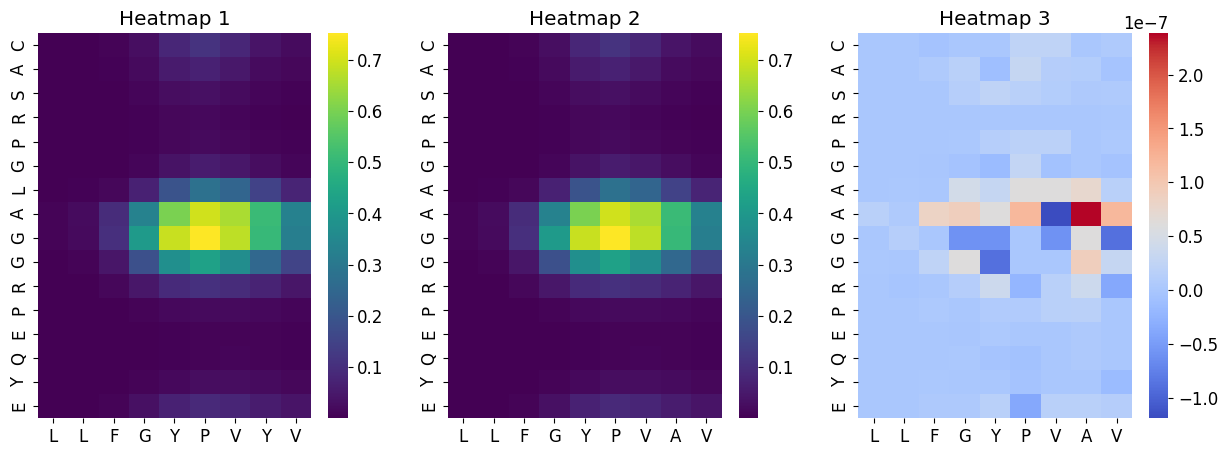

In [19]:
## OK：78，79，82
n_heads = 5
# path_saver = './train_teim/model_epoch/tansfer__multihead5_fold0_epoch82.pkl'
path_saver = 'tansfer__multihead5_fold0_epoch82.pkl'
# path_saver = './train_teim/model_epoch/tansfer__multihead5_fold0_epoch33.pkl'

model_transfer = Transformer().to(device)
model_transfer.load_state_dict(torch.load(path_saver))
import seaborn as sns
model_transfer.eval()
data, pep_inputs, hla_inputs, loader,encoding_mask = data_with_loader(type_ = 'test')
print(list(data['epitope'][0]))

# print(hla_inputs)
pred_dist, pred_bd = eval_step_corrected(model_transfer,loader,encoding_mask,threshold,use_cuda)
# print(pred_dist[1])
pred_dist_1 = pred_bd[0]*encoding_mask[0]

pred_dist_3 = pred_bd[4]*encoding_mask[4]
pred_dist = pred_dist_3-pred_dist_1
# 检查每一行是否全部为 0，如果不是，则保留该行
rows_to_keep = np.any(encoding_mask[0], axis=1)
# print(rows_to_keep)
# 检查每一列是否全部为 0，如果不是，则保留该列
cols_to_keep = np.any(encoding_mask[0], axis=0)
# print(cols_to_keep)
# 根据保留的行和列，重新构造矩阵 A
pred_dist = pred_dist[rows_to_keep][:, cols_to_keep]
pred_dist_1 = pred_dist_1[rows_to_keep][:, cols_to_keep]
pred_dist_3 = pred_dist_3[rows_to_keep][:, cols_to_keep]
temp_pd1 = pd.DataFrame(np.array(pred_dist_1.cpu()))
temp_pd3 = pd.DataFrame(np.array(pred_dist_3.cpu()))
temp_pd = pd.DataFrame(np.array(pred_dist.cpu()))
# temp_pd = temp_pd.loc[(temp_pd.sum(axis=1)!=0),(temp_pd.sum(axis=0) !=0)]
# print(encoding_mask[3])
fig = plt.figure(figsize = (10, 6))
# 创建子图
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
# 绘制第一个热图
sns.heatmap(temp_pd1, ax=axes[0], cmap='viridis',xticklabels=list(data['epitope'][0]), yticklabels=list(data['cdr3'][0]))
axes[0].set_title('Heatmap 1')
# 绘制第二个热图
sns.heatmap(temp_pd3, ax=axes[1], cmap='viridis',xticklabels=list(data['epitope'][4]), yticklabels=list(data['cdr3'][4]))
axes[1].set_title('Heatmap 2')
# 绘制第三个热图
sns.heatmap(temp_pd, ax=axes[2], cmap='coolwarm',xticklabels=list(data['epitope'][4]), yticklabels=list(data['cdr3'][4]))
axes[2].set_title('Heatmap 3')
fig.patch.set_facecolor('white')
# cmap = 'YlGnBu'
# sns.heatmap(temp_pd,cmap = 'coolwarm')

Save fasta file to tmp_faketcr.fasta
 Aligning...
['CASRPGLA----GGRPEQYE' 'CASSSRS-------SETQYF' 'CASRDPGLA--GEGHGELFF'
 'CASSSRA-------SETQYF' 'CASRPGAA----GGRPEQYE']
[[17  2 15 20 18  1  4  2  0  0  0  0  1  1 20 18 11 13  8 11]
 [17  2 15 15 15 20 15  0  0  0  0  0  0  0 15 11 16 13  8  6]
 [17  2 15 20  9 18  1  4  2  0  0  1 11  1 19  1 11  4  6  6]
 [17  2 15 15 15 20  2  0  0  0  0  0  0  0 15 11 16 13  8  6]
 [17  2 15 20 18  1  2  2  0  0  0  0  1  1 20 18 11 13  8 11]]
tensor([[ 0,  4,  4,  6,  1,  8, 18,  3,  8,  3,  0,  0],
        [ 0,  1,  5,  4,  1,  4,  3,  6, 16,  4,  0,  0],
        [ 0,  0, 20,  2, 12,  6, 12, 13,  4,  4,  0,  0],
        [ 0,  1,  5,  4,  1,  4,  3,  6, 16,  4,  0,  0],
        [ 0,  4,  4,  6,  1,  8, 18,  3,  2,  3,  0,  0]])
(5, 5, 32, 32)
[ True  True  True  True  True  True  True False False False False False
 False False  True  True  True  True  True  True]
[False  True  True  True  True  True  True  True  True  True False False]
[[0. 1. 1. 1.

sh: 1: ANARCI: not found


<Figure size 1000x600 with 0 Axes>

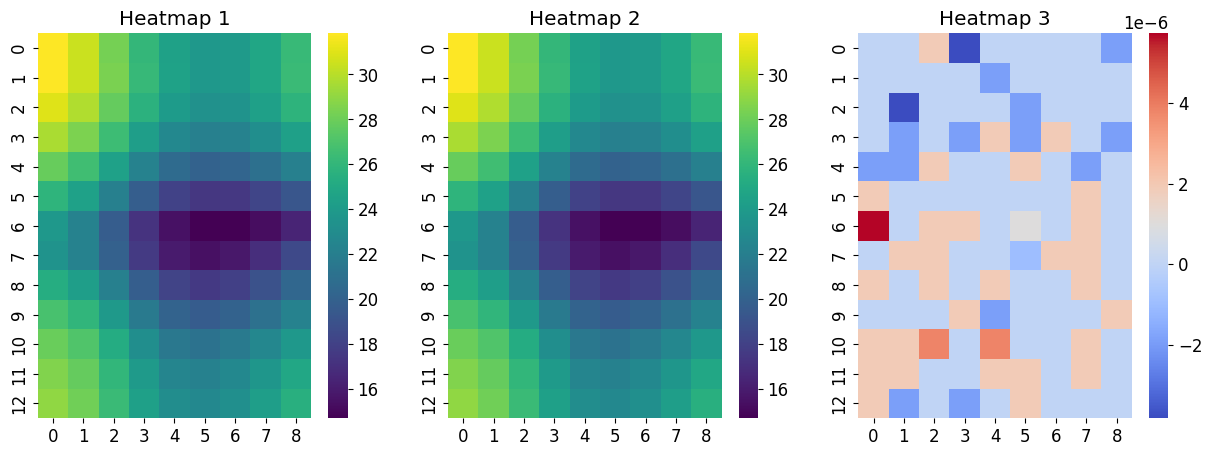

In [84]:
## OK：82
path_saver = './train_teim/model_epoch/tansfer__multihead5_fold0_epoch82.pkl'
# path_saver = './train_teim/tcr_st_layer1_multihead5_fold4_netmhcpan.pkl'
model_transfer = Transformer().to(device)
model_transfer.load_state_dict(torch.load(path_saver))
import seaborn as sns
model_transfer.eval()
data, pep_inputs, hla_inputs, loader,encoding_mask = data_with_loader(type_ = 'test')
print(pep_inputs)
# print(hla_inputs)
pred_dist, pred_bd = eval_step_corrected(model_transfer,loader,encoding_mask,threshold,use_cuda)
# print(pred_dist[1])
pred_dist_1 = pred_dist[0]*encoding_mask[0]
pred_dist_3 = pred_dist[4]*encoding_mask[4]
pred_dist = pred_dist_3-pred_dist_1

# 检查每一行是否全部为 0，如果不是，则保留该行
rows_to_keep = np.any(encoding_mask[3], axis=1)
print(rows_to_keep)
# 检查每一列是否全部为 0，如果不是，则保留该列
cols_to_keep = np.any(encoding_mask[3], axis=0)
print(cols_to_keep)
# 根据保留的行和列，重新构造矩阵 A
pred_dist = pred_dist[rows_to_keep][:, cols_to_keep]
pred_dist_1 = pred_dist_1[rows_to_keep][:, cols_to_keep]
pred_dist_3 = pred_dist_3[rows_to_keep][:, cols_to_keep]

temp_pd1 = pd.DataFrame(np.array(pred_dist_1.cpu()))
temp_pd3 = pd.DataFrame(np.array(pred_dist_3.cpu()))
temp_pd = pd.DataFrame(np.array(pred_dist.cpu()))


# temp_pd = temp_pd.loc[~(temp_pd==0).all(axis=1)]
# temp_pd = temp_pd.loc[(temp_pd.sum(axis=1)!=0),(temp_pd.sum(axis=0) !=0)]
print(encoding_mask[3])
fig = plt.figure(figsize = (10, 6))
# 创建子图
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# 绘制第一个热图
sns.heatmap(temp_pd1, ax=axes[0], cmap='viridis')
axes[0].set_title('Heatmap 1')

# 绘制第二个热图
sns.heatmap(temp_pd3, ax=axes[1], cmap='viridis')
axes[1].set_title('Heatmap 2')
# 绘制第三个热图
sns.heatmap(temp_pd, ax=axes[2], cmap='coolwarm')
axes[2].set_title('Heatmap 3')

fig.patch.set_facecolor('white')
# cmap = 'YlGnBu'
# sns.heatmap(temp_pd,cmap = 'coolwarm')

<Axes: >

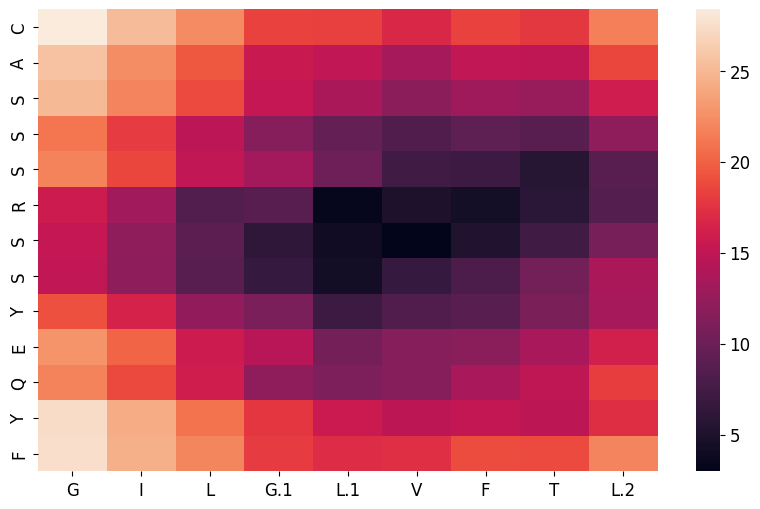

In [45]:
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# temp_pd = pd.read_csv('outputs/site_CASRDPGLAGEGHGELFF_RAKFKQLL.csv',index_col=0)
temp_pd = pd.read_csv('../TEIM-main_1/data/contact_map/5hhm_JI_H.csv',index_col=0)

temp_pd
enc_contact_mat = np.int64(temp_pd < 8.)

fig = plt.figure(figsize = (10, 6))
fig.patch.set_facecolor('white')

cmap = 'YlGnBu'
sns.heatmap(temp_pd) 
# sns.heatmap(enc_contact_mat) 

In [43]:
encoding_mask[1].shape()


(20, 12)

In [56]:
import numpy as np

# 假设有两个矩阵 A 和 mask
A = np.array([[1, 2, 3, 0],
              [0, 3, 0, 0],
              [7, 8, 9, 0],
              [0, 0, 8, 0]])

mask = np.array([[0, 0, 1, 1],
                 [0, 0, 0, 0],
                 [0, 1, 1, 1],
                 [0, 0, 0, 0]])

# 检查每一行是否全部为 0，如果不是，则保留该行
rows_to_keep = np.any(mask, axis=1)
print(rows_to_keep)
# 检查每一列是否全部为 0，如果不是，则保留该列
cols_to_keep = np.any(mask, axis=0)

# 根据保留的行和列，重新构造矩阵 A
A = A[rows_to_keep][:, cols_to_keep]

print("删除后的矩阵 A：")
print(A)


[ True False  True False]
删除后的矩阵 A：
[[2 3 0]
 [8 9 0]]
